In [1]:
from data_class_2 import *
from create_statespace_class2 import *

import matplotlib.pyplot as plt
import pandas as pd
# matplotlib inline
import numpy as np

import seaborn as sns
sns.set_theme(style="whitegrid")

from scipy.cluster.hierarchy import dendrogram, linkage

In [2]:
np.random.seed(42)
# choose which app to look at between 'EVOKE' and 'MOMENT'
app = "EVOKE"

# get the data
paths = ['part-00000-tid-5172624987854127169-b1684884-bebf-43d9-bb55-f03708dbec1f-5531-1-c000.json',
         'part-00001-tid-5172624987854127169-b1684884-bebf-43d9-bb55-f03708dbec1f-5532-1-c000.json',
         'part-00002-tid-5172624987854127169-b1684884-bebf-43d9-bb55-f03708dbec1f-5533-1-c000.json',
         'part-00003-tid-5172624987854127169-b1684884-bebf-43d9-bb55-f03708dbec1f-5534-1-c000.json']

# create the data object
data = Data(paths, app)

# clean the data
data.clean()

# create the state space
space = Space(app)

In [3]:

# create matrix for [Bass, Midrange, Treble] settings (they are currently in a list)
setting_vector = np.asarray(data.settings)
setting_vector = setting_vector.astype(int)

# get the states represented in the dataset
used_states = list(np.unique(np.asarray(data.states)))

# split the settings based on state
sets = []
dts = np.asarray(data.states)
for state in used_states:
    set_state = setting_vector[dts == state]
    sets.append(set_state)

In [4]:
# compute the X-matrix of "unraveled" cubes
X = np.zeros((len(used_states), 25*19*19))
for state in used_states:
    # get index for desired state
    index = used_states.index(state)
    set_state = sets[index]

    # count how many times each setting occurs
    state_matrix = np.zeros((25, 19, 19))
    for setting in set_state:
        state_matrix[setting[0]+12,setting[1]+12,setting[2]+12] += 1

    #make kube into vector and normalise it
    state_array = np.ravel(state_matrix)
    total = np.sum(state_array)
    if total != 0:
        state_array = state_array/total
    X[index,:] = state_array

In [22]:
from sklearn.cluster import AgglomerativeClustering
affinity_choice = 'euclidean'
linkage_choice = 'ward'
n_clusters = 11
cluster = AgglomerativeClustering(n_clusters=n_clusters, affinity=affinity_choice, linkage=linkage_choice)
cluster.fit_predict(X)




array([ 0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  8,  0,  2,  3,  2,
        0,  0,  0,  3,  9,  0,  3,  2,  0,  0,  0,  0,  2,  0,  0,  0,  0,
        1,  2,  2,  0,  0,  0,  5,  1,  0,  7,  0,  0,  1,  0,  4,  2,  1,
        2,  2,  0,  3,  0,  1,  2,  0,  0,  0,  0,  0,  0,  0,  0,  2,  0,
        0,  1,  0,  2,  2,  0,  0,  1,  2,  0,  7,  0,  0,  1,  6,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  3,  0,  0,  0,
        3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  2,  0,  0,  0,  8,  0,  0,  7,  0,  0,  0,  0,
        0,  0,  2,  0,  0,  9,  2,  0,  2,  0,  2,  0,  0,  0,  0,  0,  0,
        0, 10,  0,  0,  0,  5,  2,  0,  1,  0,  0,  0,  6,  0,  2,  3,  2,
        0,  0,  0,  2,  0,  0,  0,  0,  0,  0,  0,  0,  2,  0,  0,  2,  5,
        0,  0,  0,  0,  2,  0,  0,  0,  0,  2,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  2,  0,  0,  0,  0,  2,  0,  2,  1,  2,  0,  0,
        2,  5,  0,  0,  5

In [23]:

cluster_plot_dict = {}

cluster_plot_dict['states'] = used_states
cluster_plot_dict['clusters'] = cluster.labels_
cluster_plot_dict['envs'] = []
cluster_plot_dict['intents'] = []
cluster_plot_dict['height_env'] = []
for i in range(len(cluster.labels_)):
    state = used_states[i].split("_")
    cluster_plot_dict['envs'].append(state[0])
    if len(state) == 1:
        cluster_plot_dict['intents'].append('_')
    if len(state) == 2:
        cluster_plot_dict['intents'].append(state[1])
    elif len(state) == 3:
        cluster_plot_dict['intents'].append(state[1]+'_'+state[2])
    #cluster_plot_dict['height'].append(np.random.rand()*20)
    cluster_plot_dict['height_env'].append(space.environments.index(state[0])+np.random.rand()*0.5)
    
    
cluster_plot_df = pd.DataFrame(cluster_plot_dict)

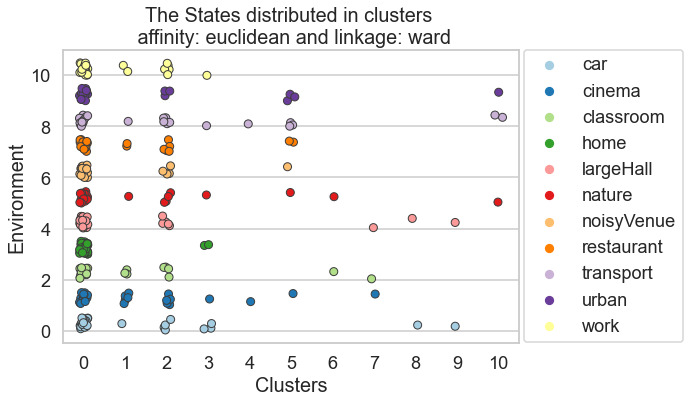

In [24]:

sns.set_context("talk", font_scale=1.1)
plt.figure(figsize=(10,6))
sns.stripplot(x="clusters", 
              y="height_env", 
              hue="envs", 
              data=cluster_plot_df,
             jitter=1, 
              size=8,
             linewidth=1, 
             palette="Paired")
plt.xlabel("Clusters")
plt.ylabel("Environment")
# place the legend outside the figure/plot
plt.legend(bbox_to_anchor=(1.01, 1),
           borderaxespad=0)
plt.title("The States distributed in clusters \n affinity: {} and linkage: {}".format(affinity_choice, linkage_choice))
plt.tight_layout()
filename = 'clusters_' + str(n_clusters) + '_' + 'affinity_' + affinity_choice + '_linkage_' + linkage_choice +'hue_env_'+'.png'
plt.savefig(filename)
plt.show()

C:\Users\frede\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


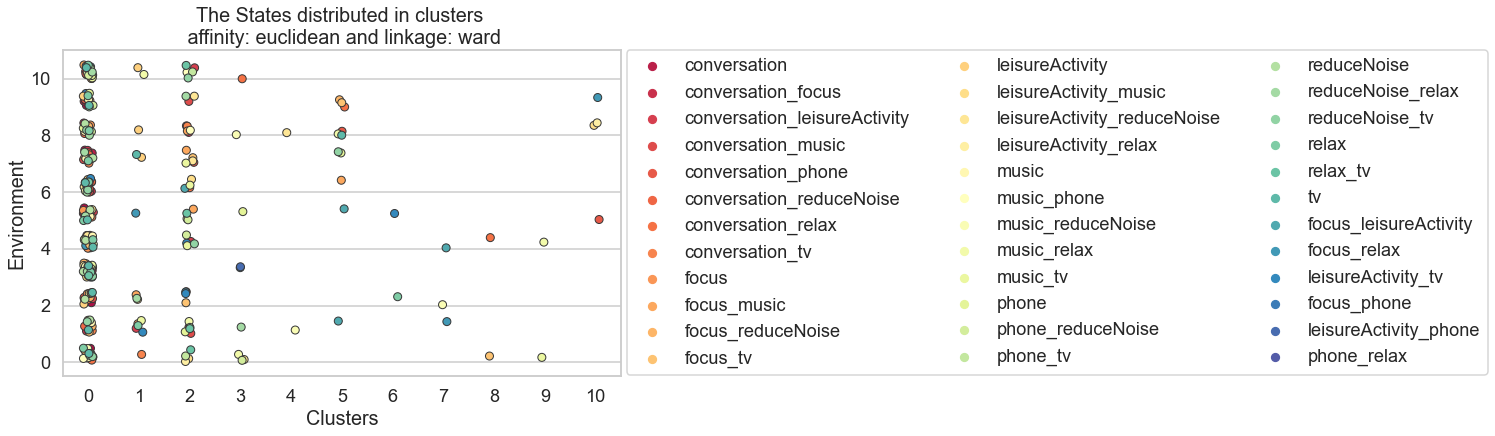

In [45]:

sns.set_context("talk", font_scale=1.1)
plt.figure(figsize=(10,6))
sns.stripplot(x="clusters", 
              y="height_env", 
              hue="intents", 
              data=cluster_plot_df,
             jitter=1, 
              size=8,
             linewidth=1, 
             palette="Spectral")
plt.xlabel("Clusters")
plt.ylabel("Environment")
# place the legend outside the figure/plot
plt.legend(bbox_to_anchor=(1.01, 1),
           borderaxespad=0, ncol=3)
plt.title("The States distributed in clusters \n affinity: {} and linkage: {}".format(affinity_choice, linkage_choice))
plt.tight_layout()
filename = 'clusters_' + str(n_clusters) + '_' + 'affinity_' + affinity_choice + '_linkage_' + linkage_choice +'_hue_intent'+'.png'
fig.savefig(filename, bbox_inches='tight')
plt.show()

In [19]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)




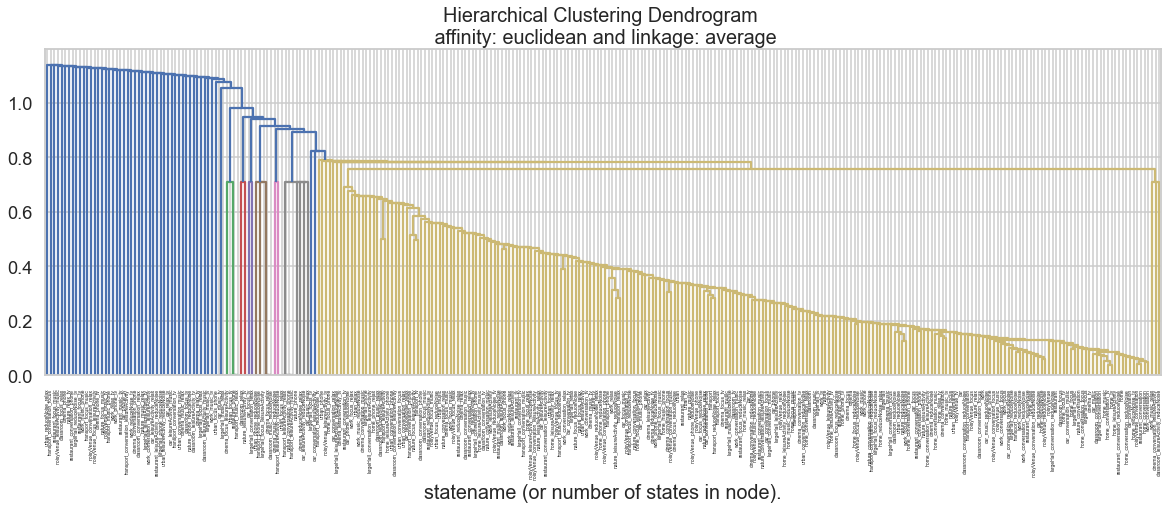

In [20]:
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity=affinity_choice, linkage=linkage_choice)

model = model.fit(X)
labelList = used_states

plt.figure(figsize=(20,6))
plt.title('Hierarchical Clustering Dendrogram \n affinity: {} and linkage: {}'.format(affinity_choice, linkage_choice))
# plot dendrogram
# add to only show top 3 levels: , truncate_mode='level', p=3
plot_dendrogram(model, labels=labelList)
plt.xlabel("statename (or number of states in node).")
filename = 'dendrogram_' + 'affinity_' + affinity_choice + '_linkage_' + linkage_choice +'.png'
plt.savefig(filename)
plt.show()